In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Leer csv
df_tiendas = pd.read_csv('/content/drive/MyDrive/2024/2do Cuatri - 2024/Proyecto Final/TP Proyecto/Código/tiendas_caba.csv')

Mounted at /content/drive


In [ ]:
import geopandas as gpd

provincia = gpd.read_file('/content/drive/MyDrive/provincia.shp')
caba = provincia[provincia['nam'].isin(['Ciudad Autónoma de Buenos Aires'])]
caba = caba.to_crs(epsg=3857)

In [ ]:
df_tiendas

,id,geometry
0,bytearray(b'\x00\x1d\xdd\x81KQK\x90\xacS\x95\x...,POINT (-58.48588969999999 -34.572622)
1,"bytearray(b""\x00@\'\xb8\xcd\xa8Jl\x94`\x99\xc7...",POINT (-58.4194457 -34.6337084)
2,bytearray(b'\x00\x82~\xaf\x1f\nB\x15\xbb\xca\x...,POINT (-58.51785169999999 -34.63999039999999)
3,bytearray(b'\x00\x9e9\x05g\xf3\x11\xec\x96\xe9...,POINT (-58.44009229999999 -34.6089076)
4,bytearray(b'\x00\xe2\xa9\x11\xd3\xf3H}\x8a8~*!...,POINT (-58.42735009999999 -34.6034598)
...,...,...
4482,bytearray(b'\xfe\xa9\xa8\xdd\xd8\xe6J\x16\x93\...,POINT (-58.35132580000001 -34.6146431)
4483,bytearray(b'\xff\x02\xd9\xb4g\xf1\x11\xec\x96\...,POINT (-58.4098019 -34.605285)
4484,bytearray(b'\xff\x18\xbaA\x87\xf1B(\x85\x12~\x...,POINT (-58.4739806 -34.5483677)
4485,bytearray(b'\xffq\xf5(]/Mm\x88h\xf5h \x1a\xfa%'),POINT (-58.4951783 -34.5753254)


In [ ]:
from shapely import wkt

# Asegúrate de que la columna 'geometry' es de tipo string
df_tiendas['geometry'] = df_tiendas['geometry'].astype(str)

# Convertir la columna de WKT a geometría
df_tiendas['geometry'] = df_tiendas['geometry'].apply(wkt.loads)

# Crear un GeoDataFrame con la columna de geometría
tiendas_gdf = gpd.GeoDataFrame(df_tiendas, geometry='geometry', crs='EPSG:4326')

In [ ]:
from scipy.spatial import KDTree
import numpy as np

# Reproyectar a CRS proyectado adecuado para cálculos de distancia (por ejemplo, EPSG:3857)
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)

# Extraer las coordenadas x, y de las geometrías
coords = np.array(list(zip(tiendas_gdf.geometry.x, tiendas_gdf.geometry.y)))

# Construir el KDTree
tree = KDTree(coords)

# Encontrar la distancia al vecino más cercano para cada tienda
distances, _ = tree.query(coords, k=2)  # k=2 porque el primero es la distancia a sí mismo (0)

# El vecino más cercano será el segundo, ya que el primero es la tienda en sí (distancia 0)
tiendas_gdf['tienda_mas_cercana'] = distances[:, 1]

print(tiendas_gdf[['geometry', 'tienda_mas_cercana']])

                               geometry  tienda_mas_cercana
0     POINT (-6510619.460 -4105952.792)            0.000000
1     POINT (-6503222.948 -4114214.323)            2.918485
2     POINT (-6514177.454 -4115064.267)           43.474856
3     POINT (-6505521.317 -4110859.446)           88.049051
4     POINT (-6504102.862 -4110122.640)            5.596555
...                                 ...                 ...
4482  POINT (-6495639.875 -4111635.215)         1357.930850
4483  POINT (-6502149.405 -4110369.490)           41.857453
4484  POINT (-6509293.745 -4102674.242)          158.898918
4485  POINT (-6511653.462 -4106318.280)          290.641780
4486  POINT (-6510649.104 -4107947.995)           14.787963

[4487 rows x 2 columns]


# **ESCUELAS**

In [ ]:
escuelas = pd.read_csv('/content/drive/MyDrive/establecimientos_educativos.csv')

In [ ]:
escuelas.columns

Index(['WKT', 'id', 'cui', 'cueanexo', 'cue', 'anexo', 'sector', 'dom_edific',
       'dom_establ', 'nombre_est', 'nombre_abr', 'telefono', 'email',
       'codpost', 'web_megcba', 'nivel', 'nivmod', 'nivelmodal', 'tipest',
       'tipest_abr', 'depfun', 'depfun_otr', 'de', 'comuna', 'barrio',
       'area_progr', 'estado', 'point_x', 'point_y'],
      dtype='object')

In [ ]:
# Convertir la columna de WKT a geometría
escuelas['geometry'] = escuelas['WKT'].apply(wkt.loads)

# Crear un GeoDataFrame con la columna de geometría
escuelas_gdf = gpd.GeoDataFrame(escuelas, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Reproyectar a CRS proyectado adecuado
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
escuelas_gdf = escuelas_gdf.to_crs(epsg=3857)

# Crear buffers
tiendas_gdf['buffer_200m'] = tiendas_gdf.geometry.buffer(200)
tiendas_gdf['buffer_1000m'] = tiendas_gdf.geometry.buffer(1000)

In [ ]:
# Crear GeoDataFrames para los buffers
tiendas_gdf_buffers_200m = tiendas_gdf.copy()
tiendas_gdf_buffers_200m['geometry'] = tiendas_gdf_buffers_200m['buffer_200m']

tiendas_gdf_buffers_1000m = tiendas_gdf.copy()
tiendas_gdf_buffers_1000m['geometry'] = tiendas_gdf_buffers_1000m['buffer_1000m']

# Realizar la unión espacial para encontrar escuelas dentro de los buffers
tiendas_escuelas_200m = gpd.sjoin(escuelas_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')
tiendas_escuelas_1000m = gpd.sjoin(escuelas_gdf, tiendas_gdf_buffers_1000m[['geometry']], how='left', predicate='within')

In [ ]:
# Contar cuántas escuelas caen dentro del buffer para cada tienda
escuelas_cercanas_200m = tiendas_escuelas_200m.groupby('index_right').size()
escuelas_cercanas_1000m = tiendas_escuelas_1000m.groupby('index_right').size()

tiendas_gdf['escuelas_cercanas_200m'] = tiendas_gdf.index.map(escuelas_cercanas_200m).fillna(0)
tiendas_gdf['escuelas_cercanas_1000m'] = tiendas_gdf.index.map(escuelas_cercanas_1000m).fillna(0)

In [ ]:
# Calcular promedios
mean_escuelas_200m = tiendas_gdf["escuelas_cercanas_200m"].mean()
mean_escuelas_1000m = tiendas_gdf["escuelas_cercanas_1000m"].mean()

print(f"Promedio de escuelas cercanas a 200m: {mean_escuelas_200m}")
print(f"Promedio de escuelas cercanas a 1000m: {mean_escuelas_1000m}")

Promedio de escuelas cercanas a 200m: 2.071317138399822
Promedio de escuelas cercanas a 1000m: 46.62625362157343


In [ ]:
print("CRS de tiendas_gdf:", tiendas_gdf.crs)
print("CRS de escuelas_gdf:", escuelas_gdf.crs)
print("CRS de caba:", caba.crs)

CRS de tiendas_gdf: EPSG:3857
CRS de escuelas_gdf: EPSG:3857
CRS de caba: EPSG:3857


<ipython-input-15-f144846544f5>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


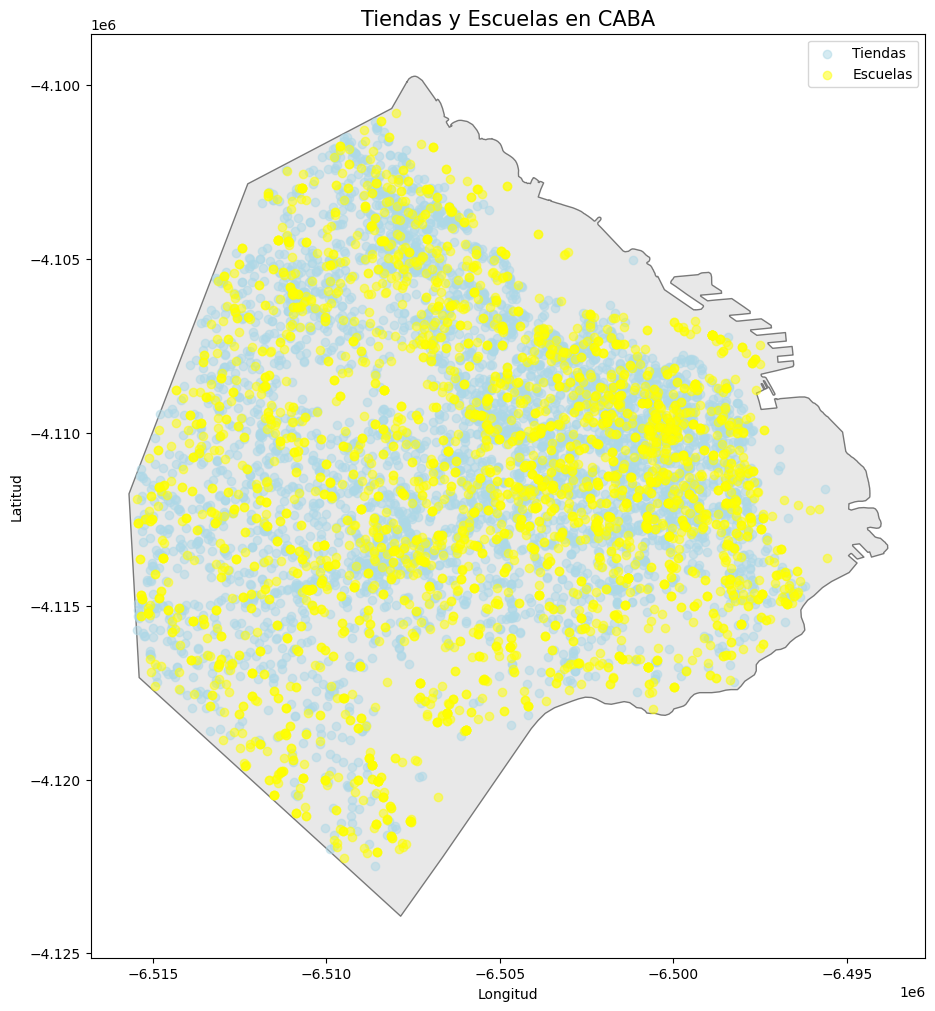

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar escuelas
escuelas_gdf.plot(ax=ax, color='yellow', alpha=0.5, label='Escuelas')

# Agregar título y etiquetas
ax.set_title('Tiendas y Escuelas en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
tiendas_gdf.columns

Index(['id', 'geometry', 'tienda_mas_cercana', 'buffer_200m', 'buffer_1000m',
       'escuelas_cercanas_200m', 'escuelas_cercanas_1000m',
       'paradas_cercanas_200m', 'paradas_cercanas_1000m'],
      dtype='object')

# **PARADAS DE COLECTIVO**

In [ ]:
paradas = pd.read_csv('/content/drive/MyDrive/paradas_colectivo.csv')

In [ ]:
paradas.columns

Index(['CALLE', 'ALT PLANO', 'DIRECCION', 'coord_X', 'coord_Y', 'COMUNA',
       'BARRIO', 'L1', 'l1_sen', 'L2', 'l2_sen', 'L3', 'l3_sen', 'L4',
       'l4_sen', 'L5', 'l5_sen', 'L6', 'l6_sen'],
      dtype='object')

In [ ]:
from shapely.geometry import Point

# Crear la columna de geometría a partir de las coordenadas
paradas['geometry'] = paradas.apply(lambda row: Point(row['coord_X'], row['coord_Y']), axis=1)

# Crear un GeoDataFrame
paradas_gdf = gpd.GeoDataFrame(paradas, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Reproyectar a CRS proyectado adecuado
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
paradas_gdf = paradas_gdf.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial para encontrar paradas dentro de los buffers
tiendas_paradas_200m = gpd.sjoin(paradas_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')
tiendas_paradas_1000m = gpd.sjoin(paradas_gdf, tiendas_gdf_buffers_1000m[['geometry']], how='left', predicate='within')

In [ ]:
# Contar cuántas paradas caen dentro del buffer para cada tienda
paradas_cercanas_200m = tiendas_paradas_200m.groupby('index_right').size()
paradas_cercanas_1000m = tiendas_paradas_1000m.groupby('index_right').size()

tiendas_gdf['paradas_cercanas_200m'] = tiendas_gdf.index.map(paradas_cercanas_200m).fillna(0)
tiendas_gdf['paradas_cercanas_1000m'] = tiendas_gdf.index.map(paradas_cercanas_1000m).fillna(0)

In [ ]:
# Calcular promedios
mean_paradas_200m = tiendas_gdf["paradas_cercanas_200m"].mean()
mean_paradas_1000m = tiendas_gdf["paradas_cercanas_1000m"].mean()

print(f"Promedio de paradas cercanas a 200m: {mean_paradas_200m}")
print(f"Promedio de paradas cercanas a 1000m: {mean_paradas_1000m}")

Promedio de paradas cercanas a 200m: 4.6714954312458215
Promedio de paradas cercanas a 1000m: 98.13059950969468


<ipython-input-18-b6aa6760a574>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


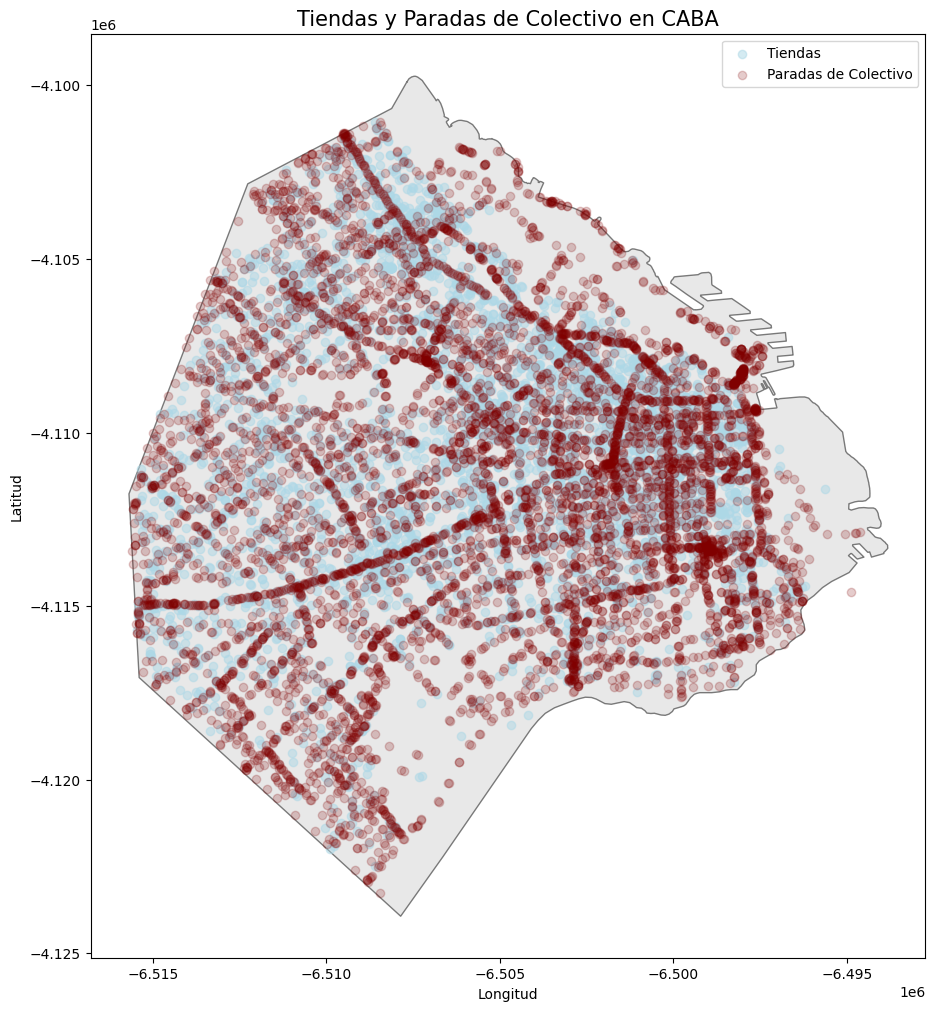

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar paradas
paradas_gdf.plot(ax=ax, color='maroon', alpha=0.2, label='Paradas de Colectivo')

# Agregar título y etiquetas
ax.set_title('Tiendas y Paradas de Colectivo en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# **ESPACIOS VERDES PÚBLICOS**

In [ ]:
everdes = pd.read_csv('/content/drive/MyDrive/espacios_verdes.csv')

In [ ]:
everdes.columns

Index(['id', 'nombre', 'nom_mapa', 'barrio', 'comuna', 'ubicacion',
       'clasificac', 'tiene_pati', 'apadrinada', 'decreto', 'fecha_decr',
       'ordenanza_', 'fecha_orde', 'boletin_of', 'fecha_bole', 'area',
       'perimetro', 'observacio', 'geometry'],
      dtype='object')

In [ ]:
# Convertir la columna 'geometry' de WKT a geometría si es necesario
everdes['geometry'] = everdes['geometry'].apply(wkt.loads)

# Crear un GeoDataFrame
everdes_gdf = gpd.GeoDataFrame(everdes, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Reproyectar a CRS proyectado adecuado
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
everdes_gdf = everdes_gdf.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial para encontrar espacios verdes dentro de los buffers
tiendas_everdes_200m = gpd.sjoin(everdes_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')
tiendas_everdes_1000m = gpd.sjoin(everdes_gdf, tiendas_gdf_buffers_1000m[['geometry']], how='left', predicate='within')

In [ ]:
# Contar cuántas paradas caen dentro del buffer para cada tienda
everdes_cercanos_200m = tiendas_everdes_200m.groupby('index_right').size()
everdes_cercanos_1000m = tiendas_everdes_1000m.groupby('index_right').size()

tiendas_gdf['everdes_cercanos_200m'] = tiendas_gdf.index.map(everdes_cercanos_200m).fillna(0)
tiendas_gdf['everdes_cercanos_1000m'] = tiendas_gdf.index.map(everdes_cercanos_1000m).fillna(0)

In [ ]:
# Calcular promedios
mean_everdes_200m = tiendas_gdf["everdes_cercanos_200m"].mean()
mean_everdes_1000m = tiendas_gdf["everdes_cercanos_1000m"].mean()

print(f"Promedio de espacios verdes cercanos a 200m: {mean_everdes_200m}")
print(f"Promedio de espacios verdes cercanos a 1000m: {mean_everdes_1000m}")

Promedio de espacios verdes cercanos a 200m: 0.3271673724091821
Promedio de espacios verdes cercanos a 1000m: 12.732783597058168


<ipython-input-211-945c490bba25>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


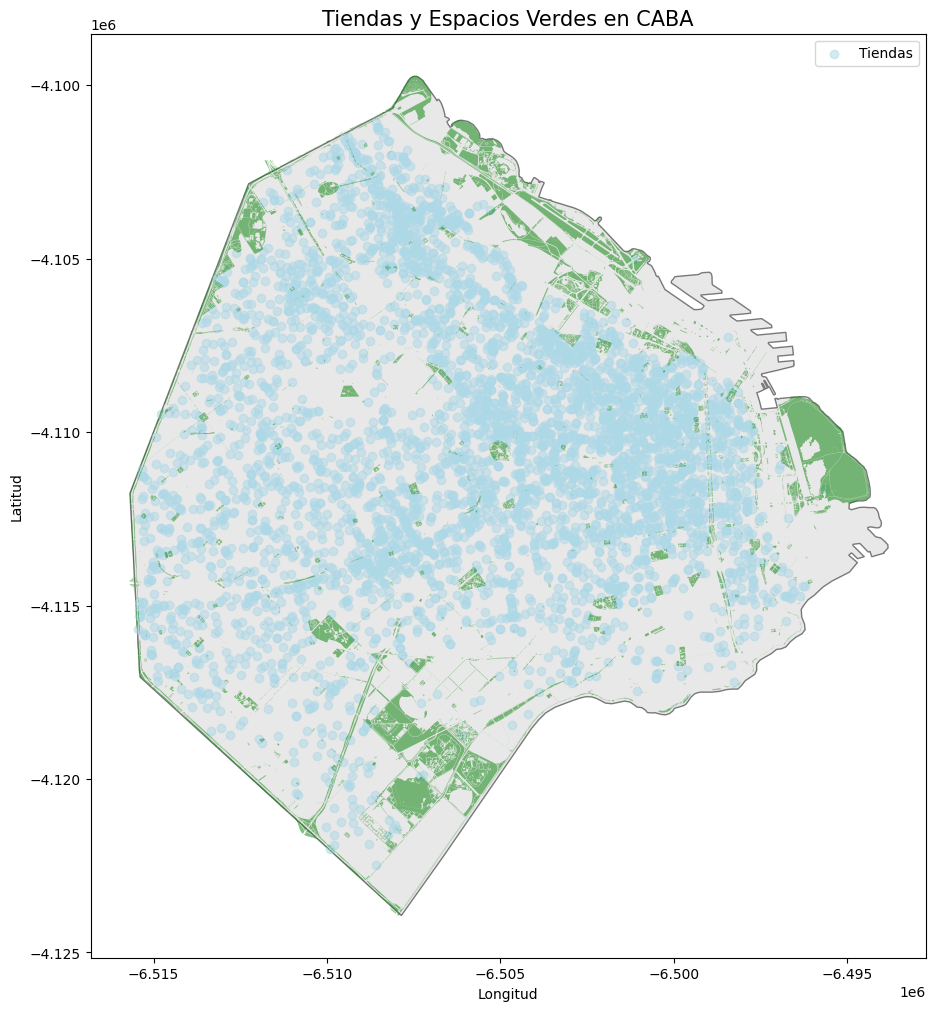

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar espacios verdes
everdes_gdf.plot(ax=ax, color='green', alpha=0.5, label='Espacios Verdes')

# Agregar título y etiquetas
ax.set_title('Tiendas y Espacios Verdes en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# **BICICLETEROS**

In [ ]:
bicicleteros = pd.read_csv('/content/drive/MyDrive/bicicleteros.csv')

In [ ]:
bicicleteros.columns

Index(['long', 'lat', 'id', 'nombre', 'anio_de_in', 'tipo', 'cantidad',
       'ubicacion', 'clasificac', 'calle', 'altura', 'calle2', 'barrio',
       'comuna', 'codigo_postal', 'codigo_postal_argentino'],
      dtype='object')

In [ ]:
# Crear una columna de geometría a partir de las coordenadas
bicicleteros['geometry'] = bicicleteros.apply(lambda row: Point(row['long'], row['lat']), axis=1)

# Crear un GeoDataFrame
bicicleteros_gdf = gpd.GeoDataFrame(bicicleteros, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Reproyectar a CRS proyectado adecuado
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
bicicleteros_gdf = bicicleteros_gdf.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial para encontrar escuelas dentro de los buffers
tiendas_bicicleteros_200m = gpd.sjoin(bicicleteros_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')

In [ ]:
# Identificar tiendas que tienen al menos un bicicletero dentro de los 200 metros
tiendas_con_bicicleteros = tiendas_bicicleteros_200m[['index_right']].drop_duplicates()
tiendas_gdf['hay_bicicleteros_200m'] = tiendas_gdf.index.isin(tiendas_con_bicicleteros['index_right']).astype(int)

# Mostrar las tiendas con la nueva columna
print(tiendas_gdf[['geometry', 'hay_bicicleteros_200m']])

                               geometry  hay_bicicleteros_200m
0     POINT (-6510619.460 -4105952.792)                      0
1     POINT (-6503222.948 -4114214.323)                      0
2     POINT (-6514177.454 -4115064.267)                      0
3     POINT (-6505521.317 -4110859.446)                      1
4     POINT (-6504102.862 -4110122.640)                      1
...                                 ...                    ...
4482  POINT (-6495639.875 -4111635.215)                      0
4483  POINT (-6502149.405 -4110369.490)                      1
4484  POINT (-6509293.745 -4102674.242)                      0
4485  POINT (-6511653.462 -4106318.280)                      0
4486  POINT (-6510649.104 -4107947.995)                      0

[4487 rows x 2 columns]


<ipython-input-25-d9a166c3304f>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


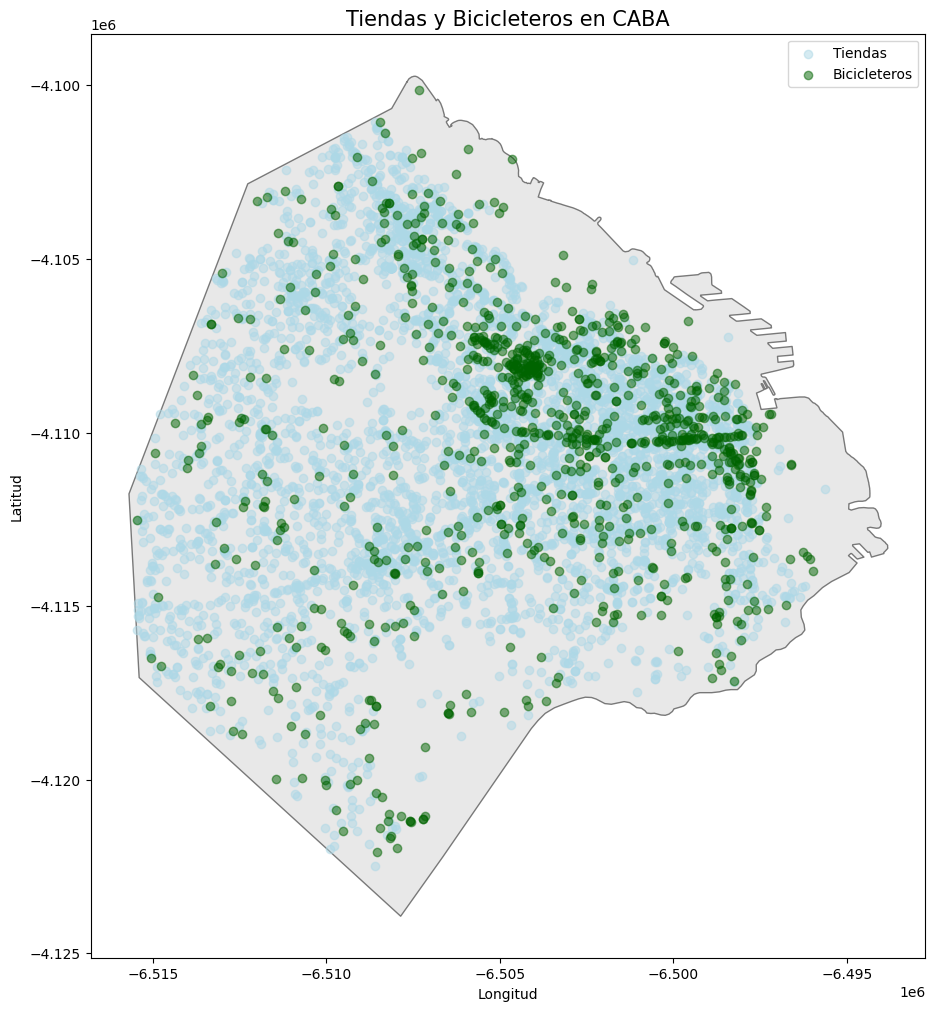

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar bicicleteros
bicicleteros_gdf.plot(ax=ax, color='darkgreen', alpha=0.5, label='Bicicleteros')

# Agregar título y etiquetas
ax.set_title('Tiendas y Bicicleteros en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
print(tiendas_gdf.columns)

Index(['id', 'geometry', 'tienda_mas_cercana', 'buffer_200m', 'buffer_1000m',
       'escuelas_cercanas_200m', 'escuelas_cercanas_1000m',
       'paradas_cercanas_200m', 'paradas_cercanas_1000m',
       'everdes_cercanos_200m', 'everdes_cercanos_1000m',
       'hay_bicicleteros_200m'],
      dtype='object')


# **HOSPITALES**

In [ ]:
hospitales = pd.read_csv('/content/drive/MyDrive/hospitales.csv')

In [ ]:
hospitales.columns

Index(['WKT', 'ID', 'NOMBRE', 'NOM_MAP', 'OBJETO', 'CALLE', 'ALTURA',
       'DOM_NORMA', 'DOM_GEO', 'TELEFONO', 'GUARDIA', 'FAX', 'WEB',
       'COD_POSTAL', 'TIPO', 'TIPO_ESPEC', 'MOD_AT_1', 'MOD_AT_2',
       'DEPEND_ADM', 'DIRECTOR'],
      dtype='object')

In [ ]:
# Convertir la columna de WKT a geometría
hospitales['geometry'] = hospitales['WKT'].apply(wkt.loads)

# Crear un GeoDataFrame
hospitales_gdf = gpd.GeoDataFrame(hospitales, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Reproyectar a CRS proyectado adecuado
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
hospitales_gdf = hospitales_gdf.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial para encontrar escuelas dentro de los buffers
tiendas_hospitales_200m = gpd.sjoin(hospitales_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')
tiendas_hospitales_1000m = gpd.sjoin(hospitales_gdf, tiendas_gdf_buffers_1000m[['geometry']], how='left', predicate='within')

In [ ]:
# Contar cuántas paradas caen dentro del buffer para cada tienda
hospitales_cercanos_200m = tiendas_hospitales_200m.groupby('index_right').size()
hospitales_cercanos_1000m = tiendas_hospitales_1000m.groupby('index_right').size()

tiendas_gdf['hospitales_cercanos_200m'] = tiendas_gdf.index.map(hospitales_cercanos_200m).fillna(0)
tiendas_gdf['hospitales_cercanos_1000m'] = tiendas_gdf.index.map(hospitales_cercanos_1000m).fillna(0)

In [ ]:
# Calcular promedios
mean_hospitales_200m = tiendas_gdf["hospitales_cercanos_200m"].mean()
mean_hospitales_1000m = tiendas_gdf["hospitales_cercanos_1000m"].mean()

print(f"Promedio de hospitales cercanos a 200m: {mean_hospitales_200m}")
print(f"Promedio de hospitales cercanos a 1000m: {mean_hospitales_1000m}")

Promedio de hospitales cercanos a 200m: 0.01337196344996657
Promedio de hospitales cercanos a 1000m: 0.4296857588589258


In [ ]:
# Calcular la distancia al hospital más cercano
from shapely.ops import nearest_points

def distancia_al_hospital_mas_cercano(row, hospitales_gdf):
    if not hospitales_gdf.empty:
        nearest_geom = nearest_points(row['geometry'], hospitales_gdf.unary_union)
        return row['geometry'].distance(nearest_geom[1])
    else:
        return float('inf')

tiendas_gdf['distancia_al_hospital_mas_cercano'] = tiendas_gdf.apply(
    lambda row: distancia_al_hospital_mas_cercano(row, hospitales_gdf), axis=1
)

print(tiendas_gdf[['distancia_al_hospital_mas_cercano']])

      distancia_al_hospital_mas_cercano
0                           1940.588025
1                           1591.860108
2                           1268.720265
3                            235.154258
4                            816.697509
...                                 ...
4482                        2469.488622
4483                        1521.296094
4484                        2278.201770
4485                        3021.000011
4486                        1676.291196

[4487 rows x 1 columns]


<ipython-input-223-908c21a5e724>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


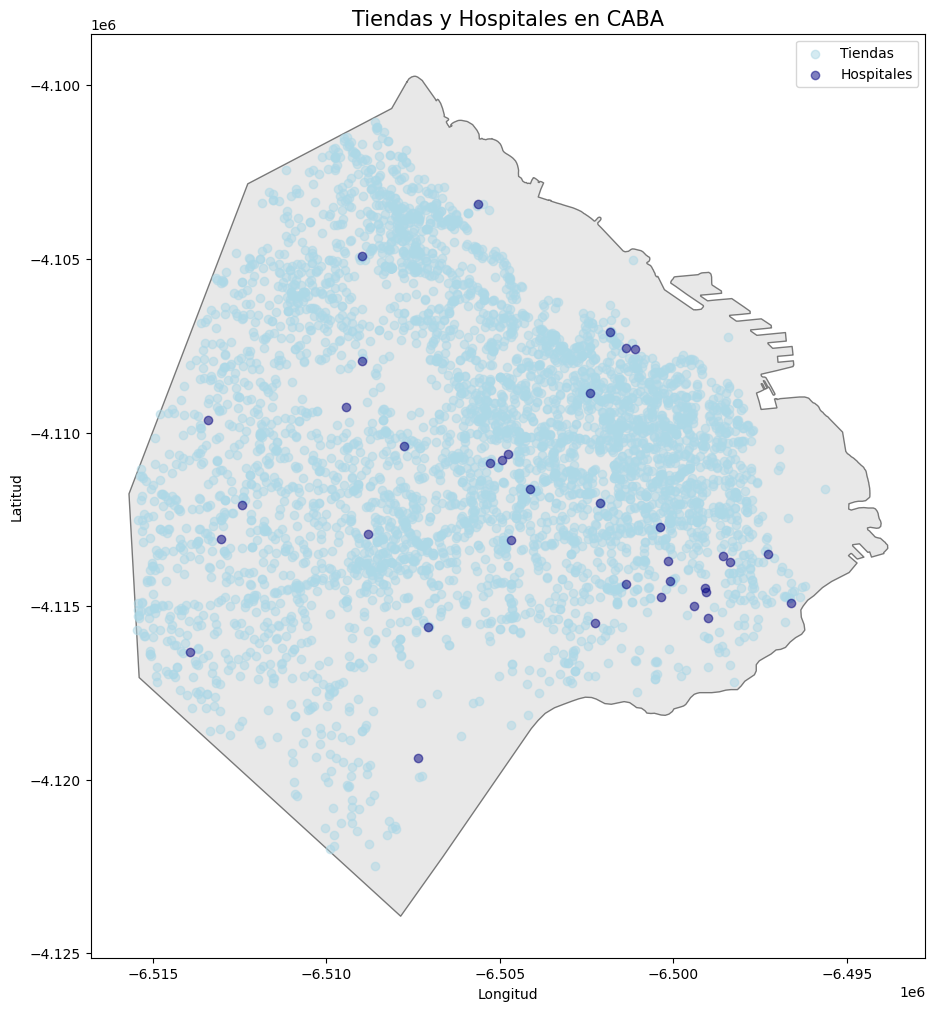

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar hospitales
hospitales_gdf.plot(ax=ax, color='navy', alpha=0.5, label='Hospitales')

# Agregar título y etiquetas
ax.set_title('Tiendas y Hospitales en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# **PARROQUIAS**

In [ ]:
parroquias = pd.read_csv('/content/drive/MyDrive/parroquias.csv')

In [ ]:
parroquias.columns

Index(['long', 'lat', 'id', 'nombre', 'referencia', 'calle', 'altura',
       'altura_2', 'cruce', 'detalle_ub', 'localidad', 'tel', 'mail',
       'nom_mapa', 'barrio', 'comuna', 'codigo_postal',
       'codigo_postal_argentino'],
      dtype='object')

In [ ]:
# Crear una columna de geometría a partir de las coordenadas
parroquias['geometry'] = parroquias.apply(lambda row: Point(row['long'], row['lat']), axis=1)

# Crear un GeoDataFrame
parroquias_gdf = gpd.GeoDataFrame(parroquias, geometry='geometry', crs='EPSG:4326')

# Reproyectar a CRS proyectado adecuado (por ejemplo, EPSG:3857 para distancias en metros)
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
parroquias_gdf = parroquias_gdf.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial para encontrar escuelas dentro de los buffers
tiendas_parroquias_200m = gpd.sjoin(parroquias_gdf, tiendas_gdf_buffers_200m[['geometry']], how='left', predicate='within')
tiendas_parroquias_1000m = gpd.sjoin(parroquias_gdf, tiendas_gdf_buffers_1000m[['geometry']], how='left', predicate='within')

In [ ]:
# Contar cuántas paradas caen dentro del buffer para cada tienda
parroquias_cercanas_200m = tiendas_parroquias_200m.groupby('index_right').size()
parroquias_cercanas_1000m = tiendas_parroquias_1000m.groupby('index_right').size()

tiendas_gdf['parroquias_cercanas_200m'] = tiendas_gdf.index.map(parroquias_cercanas_200m).fillna(0)
tiendas_gdf['parroquias_cercanas_1000m'] = tiendas_gdf.index.map(parroquias_cercanas_1000m).fillna(0)

In [ ]:
# Calcular promedios
mean_parroquias_200m = tiendas_gdf["parroquias_cercanas_200m"].mean()
mean_parroquias_1000m = tiendas_gdf["parroquias_cercanas_1000m"].mean()

print(f"Promedio de parroquias cercanas a 200m: {mean_parroquias_200m}")
print(f"Promedio de parroquias cercanas a 1000m: {mean_parroquias_1000m}")

Promedio de parroquias cercanas a 200m: 0.11232449297971919
Promedio de parroquias cercanas a 1000m: 2.472476041898819


In [ ]:
caba = caba.to_crs(epsg=3857)
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
parroquias_gdf = parroquias_gdf.to_crs(epsg=3857)

<ipython-input-297-042a4b69ec22>:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


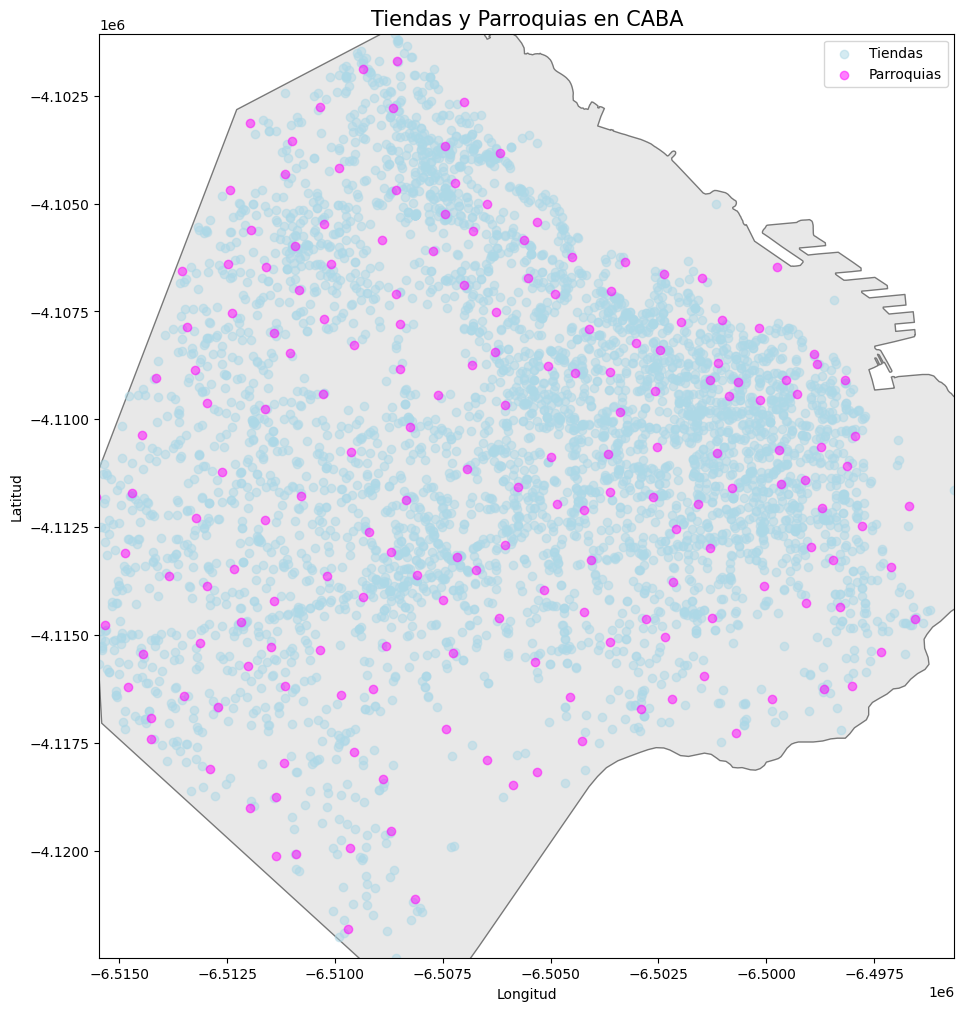

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar CABA
caba.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='CABA')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Graficar parroquias
parroquias_gdf.plot(ax=ax, color='magenta', alpha=0.5, label='Parroquias')

# Establecer proporción igual para ejes
ax.set_aspect('equal', 'box')

# Ajustar límites de los ejes si es necesario
xmin, xmax = tiendas_gdf.total_bounds[[0, 2]]
ymin, ymax = tiendas_gdf.total_bounds[[1, 3]]
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Agregar título y etiquetas
ax.set_title('Tiendas y Parroquias en CABA', fontsize=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# **COMUNAS**

In [ ]:
comunas = gpd.read_file('/content/drive/MyDrive/comunas.shp')

In [ ]:
comunas['comuna'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
tiendas_gdf = tiendas_gdf.to_crs(epsg=3857)
comunas = comunas.to_crs(epsg=3857)

In [ ]:
# Realizar la unión espacial entre tiendas y comunas
tiendas_comunas = gpd.sjoin(tiendas_gdf, comunas[['geometry', 'comuna']], how='left', predicate='within')

# Mostrar las primeras filas del resultado para verificar
print(tiendas_comunas.head())

                                                  id  \
0  bytearray(b'\x00\x1d\xdd\x81KQK\x90\xacS\x95\x...   
1  bytearray(b"\x00@\'\xb8\xcd\xa8Jl\x94`\x99\xc7...   
2  bytearray(b'\x00\x82~\xaf\x1f\nB\x15\xbb\xca\x...   
3  bytearray(b'\x00\x9e9\x05g\xf3\x11\xec\x96\xe9...   
4  bytearray(b'\x00\xe2\xa9\x11\xd3\xf3H}\x8a8~*!...   

                            geometry  tienda_mas_cercana  \
0  POINT (-6510619.460 -4105952.792)            0.000000   
1  POINT (-6503222.948 -4114214.323)            2.918485   
2  POINT (-6514177.454 -4115064.267)           43.474856   
3  POINT (-6505521.317 -4110859.446)           88.049051   
4  POINT (-6504102.862 -4110122.640)            5.596555   

                                         buffer_200m  \
0  POLYGON ((-6510419.460 -4105952.792, -6510420....   
1  POLYGON ((-6503022.948 -4114214.323, -6503023....   
2  POLYGON ((-6513977.454 -4115064.267, -6513978....   
3  POLYGON ((-6505321.317 -4110859.446, -6505322....   
4  POLYGON ((-6503902.

In [ ]:
tiendas_gdf = tiendas_gdf.join(tiendas_comunas[['comuna']], how='left')

# Verificar el resultado
print(tiendas_gdf.head())

                                                  id  \
0  bytearray(b'\x00\x1d\xdd\x81KQK\x90\xacS\x95\x...   
1  bytearray(b"\x00@\'\xb8\xcd\xa8Jl\x94`\x99\xc7...   
2  bytearray(b'\x00\x82~\xaf\x1f\nB\x15\xbb\xca\x...   
3  bytearray(b'\x00\x9e9\x05g\xf3\x11\xec\x96\xe9...   
4  bytearray(b'\x00\xe2\xa9\x11\xd3\xf3H}\x8a8~*!...   

                            geometry  tienda_mas_cercana  \
0  POINT (-6510619.460 -4105952.792)            0.000000   
1  POINT (-6503222.948 -4114214.323)            2.918485   
2  POINT (-6514177.454 -4115064.267)           43.474856   
3  POINT (-6505521.317 -4110859.446)           88.049051   
4  POINT (-6504102.862 -4110122.640)            5.596555   

                                         buffer_200m  \
0  POLYGON ((-6510419.460 -4105952.792, -6510420....   
1  POLYGON ((-6503022.948 -4114214.323, -6503023....   
2  POLYGON ((-6513977.454 -4115064.267, -6513978....   
3  POLYGON ((-6505321.317 -4110859.446, -6505322....   
4  POLYGON ((-6503902.

<ipython-input-65-1eba569308a5>:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


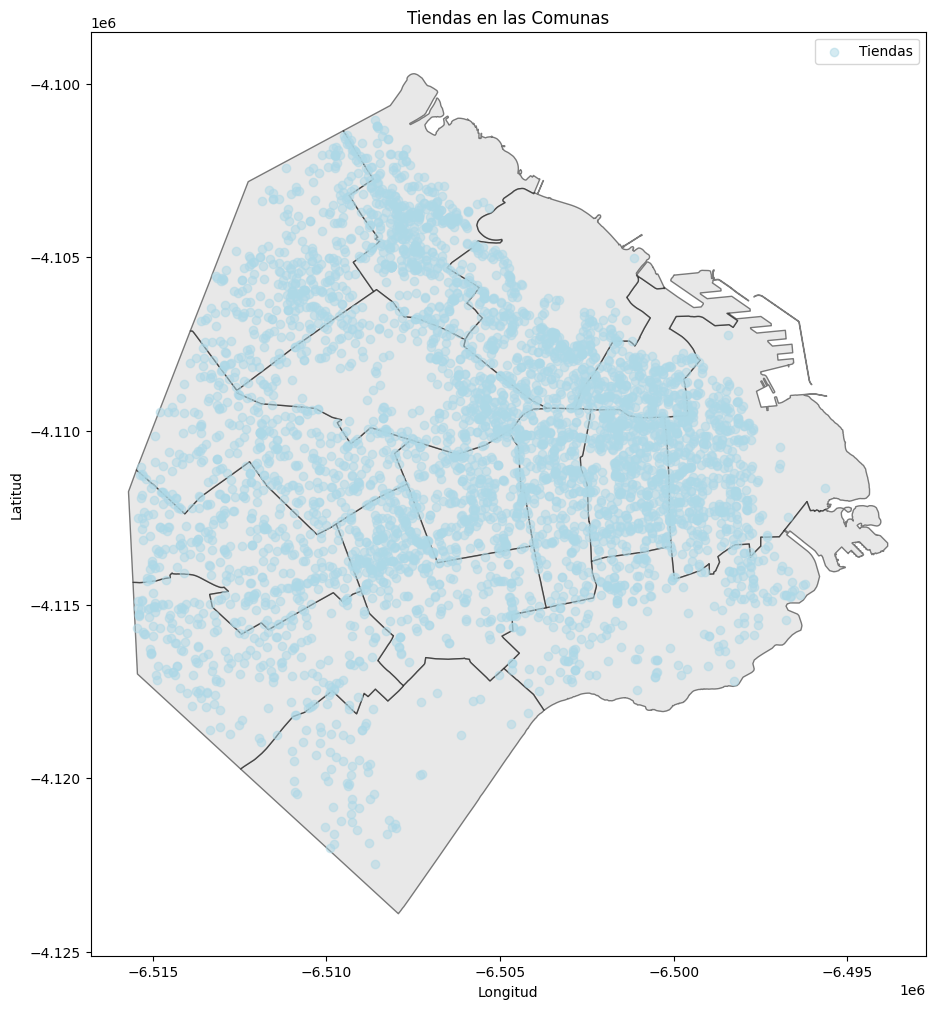

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(12, 12))

# Graficar comunas
comunas.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Comunales')

# Graficar tiendas
tiendas_gdf.plot(ax=ax, color='lightblue', alpha=0.5, label='Tiendas')

# Agregar título y etiquetas
ax.set_title('Tiendas en las Comunas')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

Guardar csv

In [ ]:
# Convertir la geometría a WKT
tiendas_gdf['geometry'] = tiendas_gdf['geometry'].apply(lambda geom: geom.wkt)

# Guardar en CSV
tiendas_gdf.to_csv('/content/drive/MyDrive/tiendas.csv', index=False)

<ipython-input-67-18222ee19682>:2: UserWarning: Geometry column does not contain geometry.
  tiendas_gdf['geometry'] = tiendas_gdf['geometry'].apply(lambda geom: geom.wkt)
